# Hands-on Lab --- Churn Modeling

## Importing some standard packages, as well as packages needed for modeling:

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

C:\Users\arunr\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## import modeling data created in the Data Prep pipeline

In [2]:
combined_df = pd.read_csv('C:\\Business Analytics\\3rd Sem\\CLV\\Team Project\\Team Project\\combined_data.csv')

## Using the head method to preview our data:

In [3]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,...,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx,demog_ownrent_trans_DO,demog_ownrent_trans_DR,demog_ownrent_trans_PO,demog_ownrent_trans_PR
0,SC,29607,567,864,1,1,1,0,0,3,...,0,0,0,0,0,1,0,1,0,0
1,MO,63901,632,573,1,1,1,0,0,9,...,0,0,0,0,0,1,1,0,0,0
2,IL,60456,602,missing,0,1,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0
3,FL,34698,539,727,1,1,1,0,0,9,...,0,0,0,0,0,1,1,0,0,0
4,CA,92084,825,760,0,1,1,0,0,1,...,0,0,0,0,0,1,1,0,0,0


## Doing some basic exploratory analysis:

In [4]:
""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
averages by churn ind
 
churn_year_plus1_ind
0    2.996402
1    2.484621
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    0.35158
1    0.00428
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.756148
1    6.150961
Name: months_since_last_trans, dtype: float64


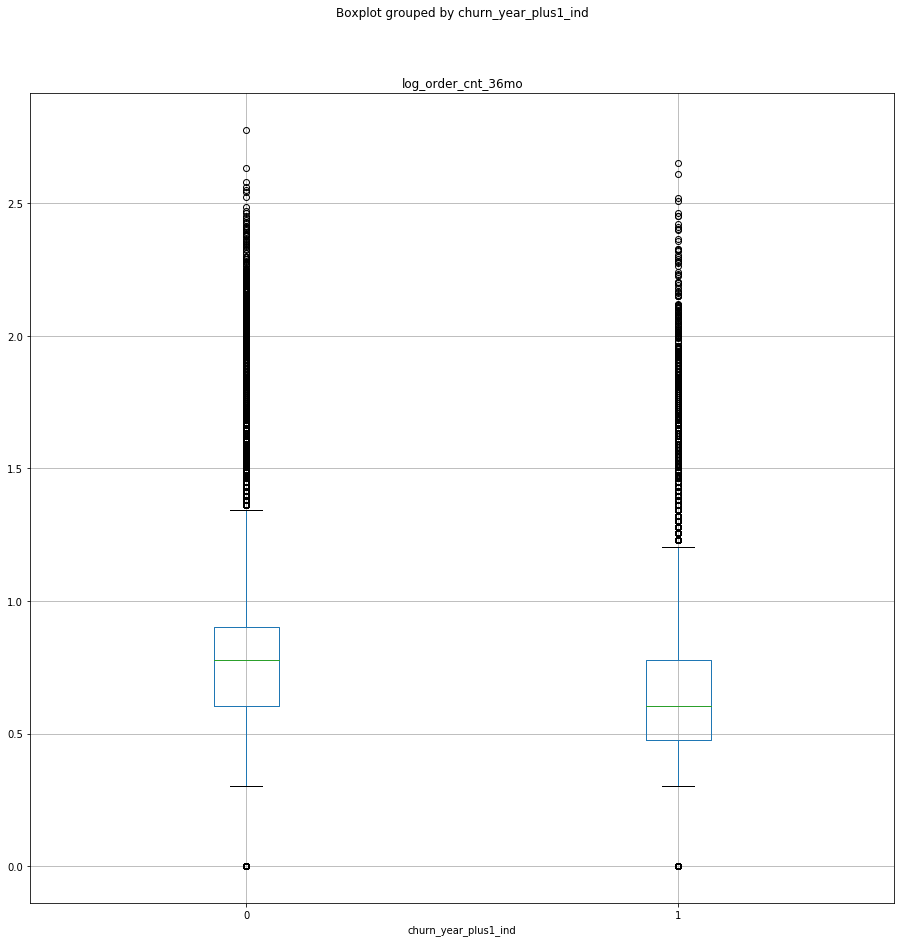

In [5]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

## Printing variable stats:

In [6]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                           count  unique         top    freq         mean  \
ST                        239356      61          TX   21540          NaN   
Zip                       239356   26096     missing     889          NaN   
DMA                       239356     216         803    9679          NaN   
Area_Cd                   239356     384     missing   13034          NaN   
emailable                 239356     NaN         NaN     NaN     0.515011   
solicit_ph_ind            239356     NaN         NaN     NaN     0.892415   
solicit_email_ind         239356     NaN         NaN     NaN     0.964079   
fixd_incm_flg             239356     NaN         NaN     NaN     0.092494   
scheduled_purchase_flg    239356     NaN         NaN     NaN     0.260039   
months_since_last_trans   239356     NaN         NaN     NaN      2.91452   
months_since_first_trans  239356     NaN         NaN     NaN      65.6307   
purch_avg_interval        239356     NaN   

## Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [7]:
[col for col in combined_df.columns if combined_df[col].isnull().any()]

['event_date']

In [8]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev','demog_ownrent_trans'
                              ],axis=1)

x_train_df.shape

(239356, 117)

## Partitioning data into Training and Test sets, creating X vs Y sets, and
##     creating dataframes with just account IDs to be used to rejoin data later:

In [9]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_train_df.shape

(167549, 113)

## Starting with a scikit_learn Logistic Regression Model
##    and using that modeling algorithm to select variables.

## Note:  change the C parameter and rerun to get reasonable number of selected vars.

In [10]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, etc """
model1 = linear_model.LogisticRegression(C=1.0, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

(102, 1)

In [11]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-0.172854
1,solicit_ph_ind,0.040598
2,solicit_email_ind,-0.101026
3,fixd_incm_flg,-0.085179
4,scheduled_purchase_flg,-4.824842
5,months_since_last_trans,0.433796
6,months_since_first_trans,-0.003680
7,purch_avg_interval,0.005536
8,mail_cnt_36mo,-0.012231
9,call_in_mo_36mo,-0.000843


## Need to introduce variable reduction that addresses multicolinearity:

In [12]:
x_train_selected_df.shape

(167549, 102)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
        
    print('Remaining variables:')
    print(X.columns[variables])
    
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

C:\Users\arunr\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'tier_1-Bronze' at index: 87
dropping 'tier_prev_1-Bronze' at index: 91
dropping 'demog_ownrent_trans_DO' at index: 96
dropping 'log_margin_3yr_avg' at index: 27
dropping 'log_margin_Y_neg_2' at index: 25
dropping 'log_margin_Y_neg_1' at index: 24
dropping 'log_purch_amt_36mo' at index: 12
dropping 'log_margin_Y_neg_3' at index: 23
dropping 'log_purch_amt_life' at index: 12
dropping 'log_purch_cnt_life' at index: 13
dropping 'perc_purch_ck_36mo' at index: 16
dropping 'log_purch_cnt_tt_36mo' at index: 13
dropping 'log_purch_avg_36mo' at index: 12
dropping 'solicit_email_ind' at index: 2
dropping 'demog_age_num' at index: 21
dropping 'log_order_cnt_36mo' at index: 10
dropping 'margin_3yr_avg' at index: 15
Remaining variables:
Index(['emailable', 'solicit_ph_ind', 'fixd_incm_flg',
       'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo',
 

(167549, 85)

## Run the step above, repeatedly, until no more variables are dropped.

In [14]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_ph_ind', 'fixd_incm_flg',
       'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo',
       'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1',
       'margin_Y_neg_2', 'demog_span', 'demog_generations', 'demog_adults',
       'demog_log_num', 'ST_AE', 'ST_AK', 'ST_AL', 'ST_AP', 'ST_AR', 'ST_AZ',
       'ST_CA', 'ST_CO', 'ST_CT', 'ST_DC', 'ST_DE', 'ST_FL', 'ST_GA', 'ST_HI',
       'ST_IA', 'ST_IL', 'ST_IN', 'ST_KS', 'ST_KY', 'ST_LA', 'ST_MA', 'ST_MD',
       'ST_ME', 'ST_MI', 'ST_MN', 'ST_MO', 'ST_MS', 'ST_MT', 'ST_NC', 'ST_ND',
       'ST_NE', 'ST_NH', 'ST_NJ', 'ST_NM', 'ST_NV', 'ST_NY', 'ST_OH', 'ST_OK',
       'ST_OR', 'ST_PA', 'ST_PR', 'ST_RI', 'ST_SC', 'ST_SD', 'ST_TN', 'ST_TX',
       'ST_UT', 'ST_VA', 'ST_VI', 'ST_VT', 'ST_WA', 'ST_WV', 'ST_WY',
       'ST_missing', 't

(71807, 85)

## Using the statsmodels package to see "friendlier" looking Logistic output:

In [15]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.318210
         Iterations 10
 
Logistic model with selected variables
 
                             Results: Logit
Model:               Logit                 Pseudo R-squared:  0.448      
Dependent Variable:  churn_year_plus1_ind  AIC:               106803.3934
Date:                2018-10-25 19:18      BIC:               107665.8900
No. Observations:    167549                Log-Likelihood:    -53316.    
Df Model:            85                    LL-Null:           -96580.    
Df Residuals:        167463                LLR p-value:       0.0000     
Converged:           1.0000                Scale:             1.0000     
No. Iterations:      10.0000                                             
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------

## Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9186239546492114
AROC test:  0.9199807634033749
 
MSE train: 0.10027718945526383
MSE test: 0.09986824633043681
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.10027718945526413
mean squared error testn: 0.09986824633043775


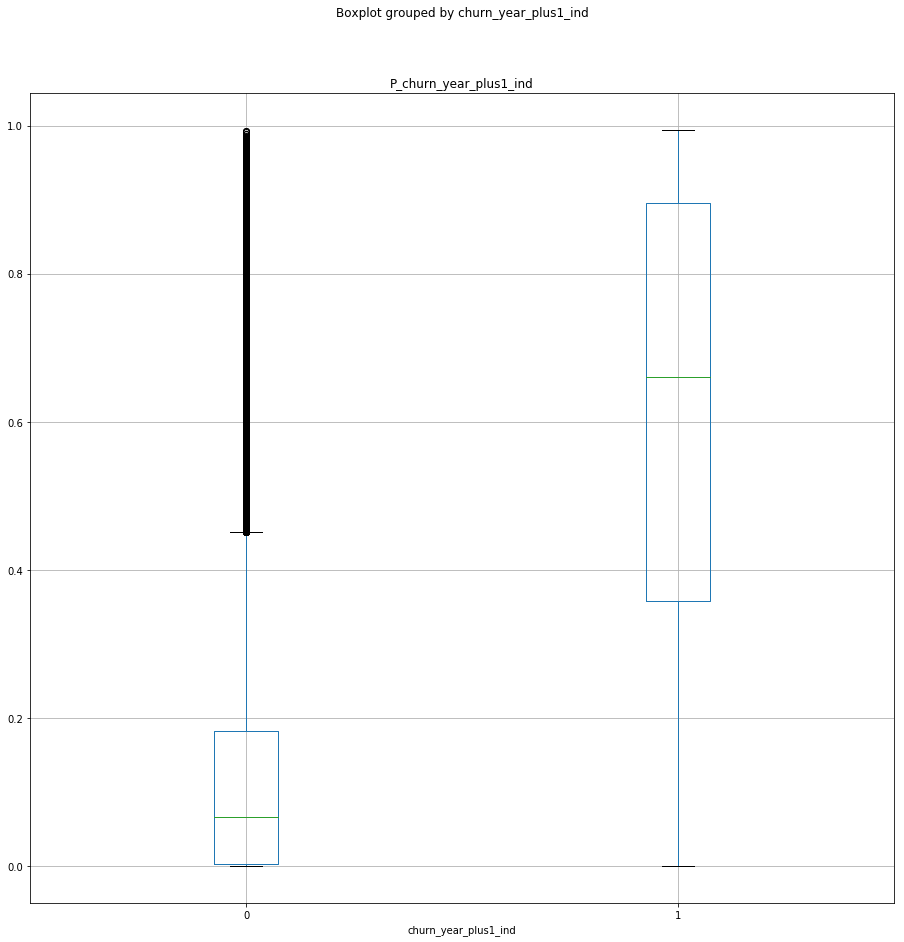

In [16]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model:

GB overall accuracy: 0.8798028047404849
AROC train:  0.9385284400102851
AROC test:  0.9367513009435348
 
MSE train: 0.08621520879603704
MSE test: 0.08706274566447907
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08621520879603754
mean squared error test: 0.08706274566447994


Text(0,0.5,'AROC')

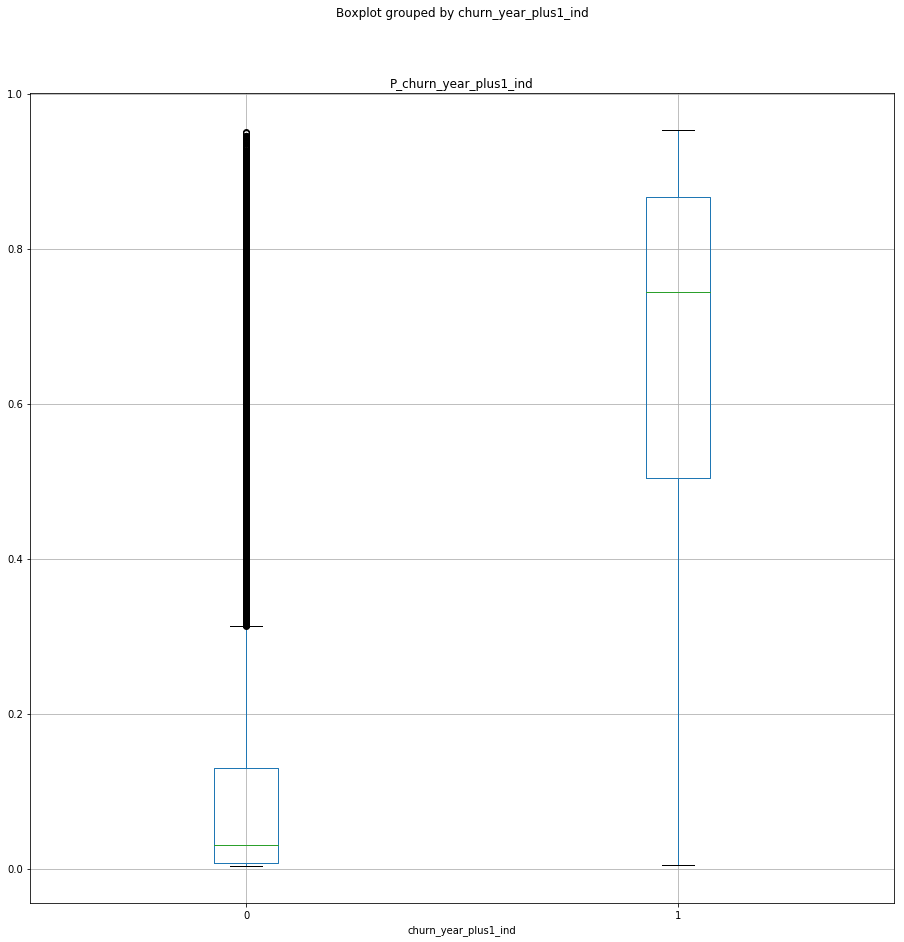

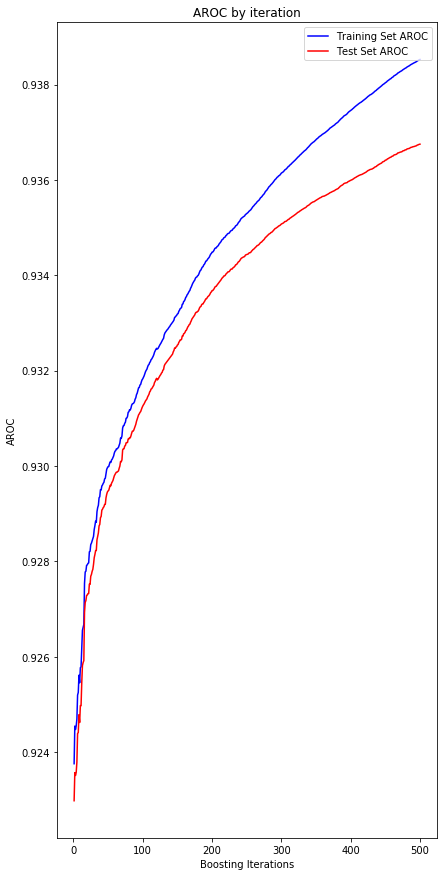

In [17]:
""" Gradient Boosting """
params = {'n_estimators': 500, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


## Feature Importance for the Gradient Boosting Model:

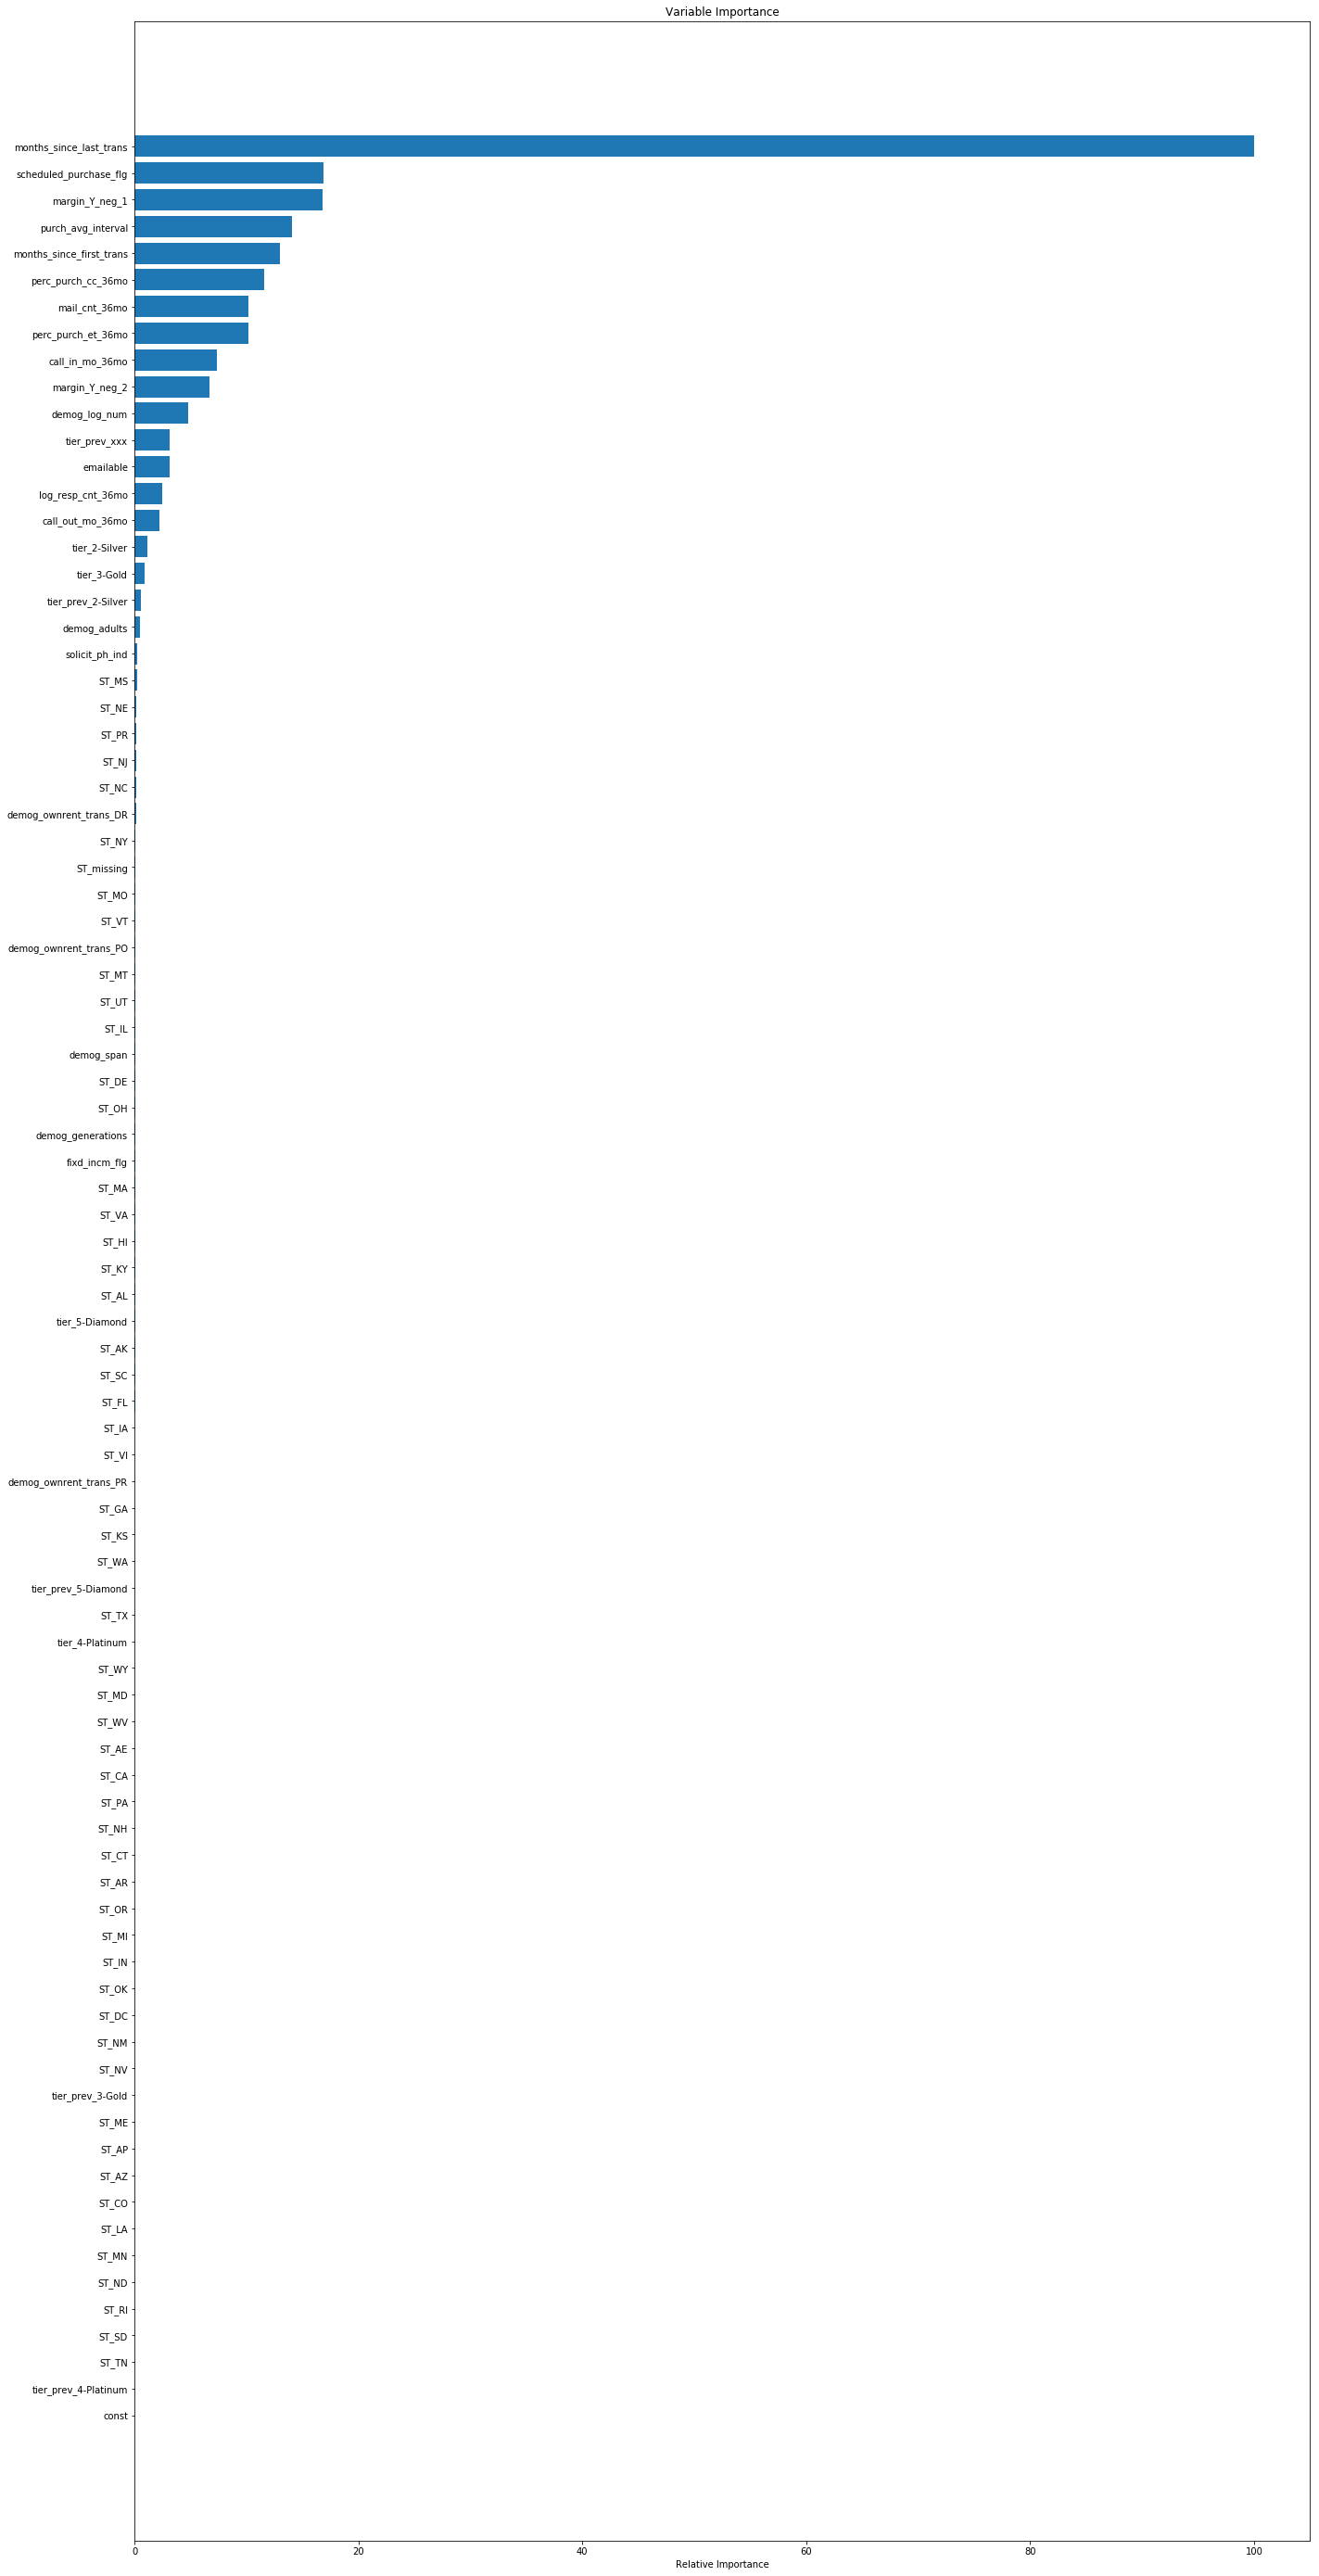

In [18]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [20]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv('C:\\Business Analytics\\3rd Sem\\CLV\\Team Project\\Team Project\\churn_scores.csv',index=False)
pred_v_actual_train.shape

C:\Users\arunr\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(311163, 2)

## (back to lecture mode)